In [6]:
import tensorflow as tf
import numpy as np
import os
import re
import matplotlib.pyplot as plt

# Function to read and parse the tensor data from a text file
def parse_tensor_from_file(file_path, shape):
    with open(file_path, 'r') as file:
        # Read the content of the file
        tensor_str = file.read()

    components = re.findall(r"([+-]?\d+\.?\d*[eE]?[+-]?\d*(?:\s*[+-]?\d*\.?\d*[eE]?[+-]?\d*j)?)", tensor_str)
    # Convert the components into a numpy array of complex numbers
    complex_numbers = [complex(c.replace(' ','')) for c in components]

    # Convert the list to a NumPy array and reshape it
    numpy_tensor = np.array(complex_numbers, dtype=np.complex128)

    if (shape == 3):
        numpy_tensor = numpy_tensor.reshape(round(numpy_tensor.size ** (1/shape)),round(numpy_tensor.size ** (1/shape)),round(numpy_tensor.size ** (1/shape)))
    if (shape == 2):
        size = numpy_tensor.size
        new_shape = (round(size ** (1/shape)), round(size ** (1/shape))) if shape == 2 else (size,)
        numpy_tensor = numpy_tensor.reshape(new_shape)
    # Convert NumPy array to TensorFlow tensor
    tf_tensor = tf.convert_to_tensor(numpy_tensor)

    return tf_tensor

def retrieve_dict(base_dir, filename):
    # Dictionary to hold costs organized by prefix (i)
    fidelity_dict = {}
    
    # Iterate through each subfolder in the base directory
    for folder_name in os.listdir(base_dir):
        folder_path = os.path.join(base_dir, folder_name)
        if os.path.isdir(folder_path):
            # Extract the prefix for identifying the 'i' value
            prefix = folder_name.split('_')[0]
            # Path to the cost.txt file
            cost_file_path = os.path.join(folder_path, filename)
            
            # Read the cost value from the cost.txt file
            if os.path.exists(cost_file_path):
                    # Extract the complex number part using regular expression
                    tensor = parse_tensor_from_file(cost_file_path, 1)
                    # Convert the extracted string to a complex number
                    for t in tensor.numpy():
                         # Get the real part and convert to float
                         float_value = t.real
                         # if (float_value < 10e-4): continue
                         if prefix not in fidelity_dict:
                              fidelity_dict[prefix] = []
                         fidelity_dict[prefix].append(abs(float_value))
    
    return fidelity_dict


def merge_dicts(dict_list, labels):
    """
    Merges multiple dictionaries into one, with new keys labeled by the given labels.

    Parameters:
        dict_list (list of dict): List of dictionaries to merge.
        labels (list of str): Labels for each dictionary.

    Returns:
        dict: Merged dictionary with new keys.
    """
    merged_dict = {}
    for i, (d, label) in enumerate(zip(dict_list, labels)):
        for key, values in d.items():
            new_key = f"{label}"
            if new_key not in merged_dict:
               merged_dict[new_key] = []
            for v in values:
                merged_dict[new_key].append(v)
    return merged_dict

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


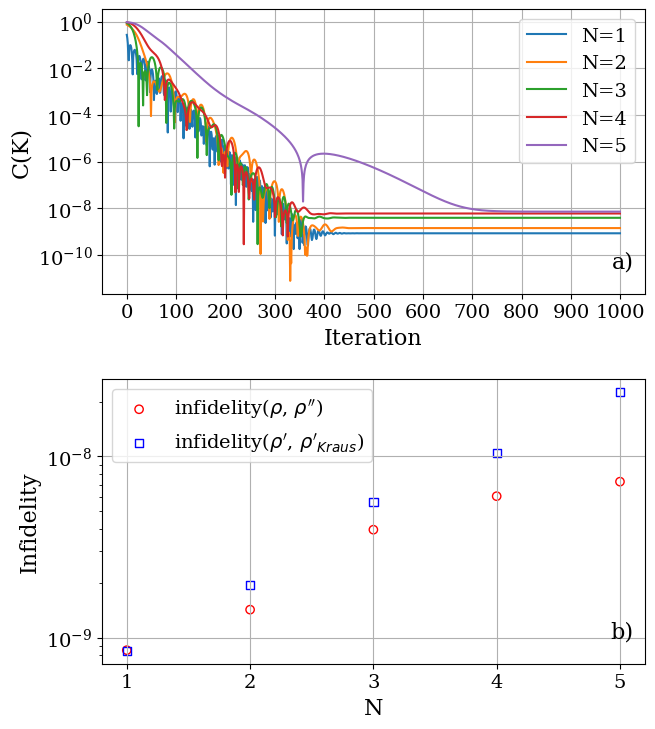

In [11]:
def plot_dict(fidelity_dict, xlabel, ylabel, file_name, max_val, step):
    # Plotting
    for i, (key, values) in enumerate(fidelity_dict.items()):
        plt.plot(values, label=f"N={key}")
    plt.xlabel(xlabel, fontsize=16)
    plt.ylabel(ylabel, fontsize=16)
    plt.yscale('log')  # Set y-axis to logarithmic scale
    x_ticks = np.arange(0, max_val, step=step)
    plt.xticks(ticks=x_ticks, fontsize=14)
    plt.yticks(fontsize=14)
    plt.grid(True)
    plt.legend(fontsize=14)

def plot_fidelity(qubits, data, xlabel, ylabel, file_name):
    # Scatter Plot
    for label, values in data.items():
        marker = 's' if 'Kraus' in label else 'o'
        color = 'blue' if 'Kraus' in label else 'red'
        plt.scatter(qubits, values, marker=marker, color=color, label=label, facecolors='none')
    plt.xlabel(xlabel, fontsize=16)
    plt.ylabel(ylabel, fontsize=16)
    plt.yscale('log')  # Set y-axis to logarithmic scale
    x_ticks = np.arange(qubits[0], qubits[-1]+1, step=1)
    plt.xticks(ticks=x_ticks, fontsize=14)
    plt.yticks(fontsize=14)
    plt.grid(True)
    plt.legend(fontsize=14)
def combined_plot(fidelity_dict, qubits, fidelity_data, xlabel_a, ylabel_a, xlabel_b, ylabel_b, file_name, max_val, step):
    # Create the figure with two subplots
    fig, axs = plt.subplots(2, 1, figsize=(7, 8.5))  # Adjust the size of the figure

    # Plot for the first subplot (a)
    plt.sca(axs[0])  # Select the first subplot
    plot_dict(fidelity_dict, xlabel_a, ylabel_a, file_name, max_val, step)
    plt.text(0.98, 0.15, 'a)', transform=axs[0].transAxes, fontsize=16, verticalalignment='top', horizontalalignment='right')

    # Plot for the second subplot (b)
    plt.sca(axs[1])  # Select the second subplot
    plot_fidelity(qubits, fidelity_data, xlabel_b, ylabel_b, file_name)
    plt.text(0.98, 0.15, 'b)', transform=axs[1].transAxes, fontsize=16, verticalalignment='top', horizontalalignment='right')
    
    plt.subplots_adjust(hspace=0.3)

    # Save the combined plot as both PNG and EPS
    plt.savefig('docs/'+file_name+'.png', format='png', bbox_inches='tight')
    plt.savefig('docs/'+file_name+'.eps', format='eps', bbox_inches='tight')

    # Display the plot
    plt.show()

plt.rc('font', family='serif')
folder_path = 'experiment_result_kraus_2'

#Get final fidelity dict
dict = retrieve_dict(folder_path, 'fidelity_rho_rho3.txt')
dict2 = retrieve_dict(folder_path, 'fidelity_rho2_rho2.txt')
qubits = [1, 2, 3, 4, 5]
merged = merge_dicts([dict, dict2], ["infidelity($\\rho$, $\\rho''$)", "infidelity($\\rho'$, $\\rho'_{Kraus}$)"])

#Get final cost dict
dict = retrieve_dict(folder_path, 'costdict.txt')

combined_plot(dict, qubits, merged, "Iteration", "C(K)", "N", "Infidelity", "cost_kraus", 1050, 100)
